In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:0


In [9]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [2]:
# Auxiliary functions
def compute_S_pows(S, K, device):
    N = S.shape[0]
    S_pows = torch.Tensor(torch.empty(K-1, N, N)).to(device)
    S_pows[0,:,:] = torch.Tensor(S).to(device)
    for k in range(1,K-1):
        S_pows[k,:,:] = S_pows[0,:,:] @ S_pows[k-1,:,:]

    return S_pows

In [3]:
# Dataset must be from DGL
dataset_name = 'CornellDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: CornellDataset
Number of nodes: 183
Number of features: 1703
Shape of signals: torch.Size([183, 1703])
Number of classes: 5
Norm of A: 17.262676239013672
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.11
Edge homophily: 0.13


In [12]:
# BEST PARAMETERS
## Reaining params
N_RUNS = 25
N_EPOCHS = 200  # 5000
LR = .05
WD = .01
DROPOUT = 0

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 2
HID_DIM = 50

## Model params
NORM = True

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ELU()  # nn.ReLU()
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.NLLLoss()  # nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [5]:
# Parameters
epochs = 500
epochs_h = 1
epochs_W = 1
lr = .05
wd = .01
drop = 0
L = N_LAYERS
K_aux = K
hid_dim = 16
h0_aux = 1  # 1
norm = False
act = ACT
lact = LAST_ACT
loss = LOSS_FN

# Create model
arch = GFGCN(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
             dropout=drop, init_h0=h0_aux)
S = torch.Tensor(A).to(device)
model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W)

idx_max_acc = np.argmax(acc["val"])
print(f'Best val acc: {acc["val"][idx_max_acc]:.3f}')
print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}')
print(f'Best test acc: {np.max(acc["test"]):.3f}')

Best val acc: 0.864
Test acc at best val: 0.784
Best test acc: 0.892


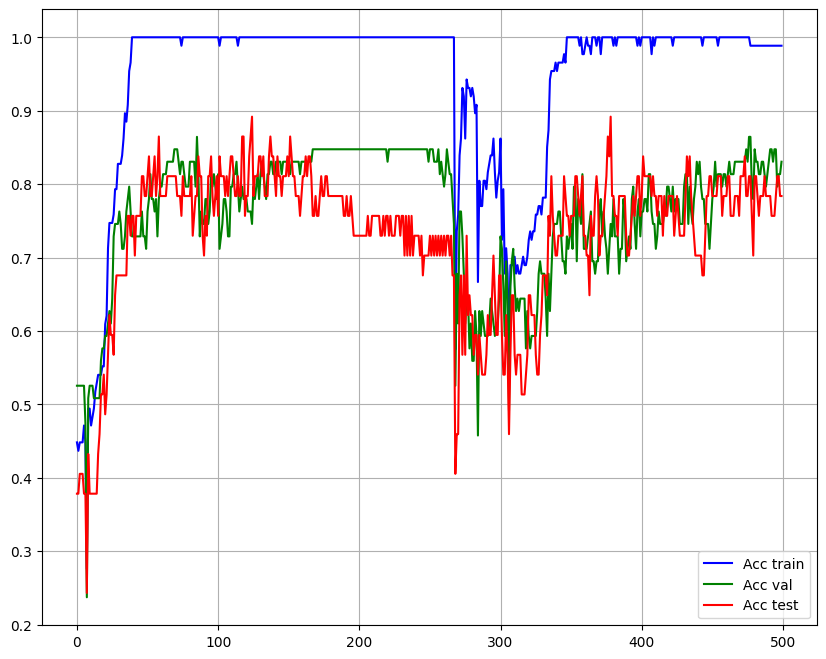

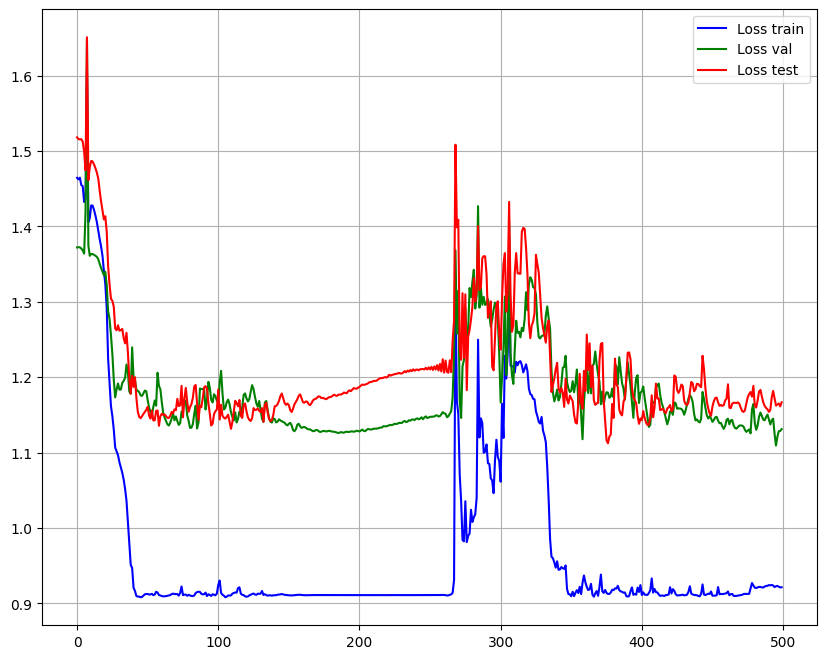

In [6]:
# Plot
plt.figure(figsize=[10,8])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[10,8])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [13]:
EXPS = [
        {'epochs': 200, 'lr': .5, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': 0},
        
        {'epochs': 200, 'lr': .05, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-2, 'drop': 0},

        {'epochs': 200, 'lr': .1, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .1, 'wd': 5e-2, 'drop': 0},
        
        {'epochs': 500, 'lr': .1, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 500, 'lr': .01, 'wd': 1e-2, 'drop': 0},

        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .75},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .25},
        {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        # {'epochs': 500, 'lr': .05, 'wd': 1e-2, 'drop': .75},

        {'epochs': 1000, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):        
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=exp['drop'], norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)

-1: 200-0.5-0.0005-0: 0.459 (0.541)
-1: 200-0.1-0.0005-0: 0.541 (0.568)
-1: 200-0.05-0.0005-0: 0.676 (0.730)
-1: 200-0.01-0.0005-0: 0.649 (0.649)
-1: 200-0.001-0.0005-0: 0.351 (0.378)
-1: 200-0.05-0.001-0: 0.351 (0.405)
-1: 200-0.05-0.01-0: 0.757 (0.838)
-1: 200-0.05-0.05-0: 0.784 (0.784)
-1: 200-0.1-0.001-0: 0.514 (0.595)
-1: 200-0.1-0.01-0: 0.649 (0.838)
-1: 200-0.1-0.05-0: 0.351 (0.514)
-1: 500-0.1-0.01-0: 0.757 (0.865)
-1: 500-0.05-0.01-0: 0.730 (0.838)
-1: 500-0.01-0.01-0: 0.757 (0.838)
-1: 200-0.05-0.01-0.25: 0.541 (0.676)
-1: 200-0.05-0.01-0.5: 0.757 (0.784)
-1: 500-0.05-0.01-0.25: 0.838 (0.838)
-1: 500-0.05-0.01-0.5: 0.757 (0.865)
-1: 1000-0.05-0.01-0: 0.730 (0.865)
-2: 200-0.5-0.0005-0: 0.541 (0.595)
-2: 200-0.1-0.0005-0: 0.432 (0.514)
-2: 200-0.05-0.0005-0: 0.622 (0.622)
-2: 200-0.01-0.0005-0: 0.595 (0.595)
-2: 200-0.001-0.0005-0: 0.351 (0.351)
-2: 200-0.05-0.001-0: 0.838 (0.838)
-2: 200-0.05-0.01-0: 0.757 (0.892)
-2: 200-0.05-0.05-0: 0.595 (0.730)
-2: 200-0.1-0.001-0: 0.405 

In [ ]:
table1

,mean accs,std
500-0.1-0.05,0.751351,0.069223
500-0.05-0.05,0.802703,0.041957
500-0.01-0.05,0.813514,0.018919
500-0.005-0.05,0.794595,0.017928
500-0.01-0.1,0.767568,0.030096
500-0.01-0.01,0.840541,0.030697
500-0.01-0.001,0.827027,0.047123
500-0.05-0.1,0.756757,0.040088
500-0.05-0.01,0.816216,0.046499
500-0.05-0.001,0.797297,0.107600


In [ ]:
table_over1

## Model params

In [7]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [{'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},        
        {'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'epochs': 200, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        {'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'epochs': 200, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},

        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        {'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'epochs': 200, 'epochs_h': 5, 'epochs_W': 25, 'alt': True},

        {'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
        {'epochs': 50, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'epochs': 50, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        if not exp['alt']:
            S_pows = compute_S_pows(A, K, device)
            model = NodeClassModel(arch, S_pows, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

-1: 1-1-True: 0.838
-1: 1-1-True: 0.730
-1: 1-1-False: 0.865
-1: 10-1-True: 0.838
-1: 25-1-True: 0.865
-1: 1-10-True: 0.838
-1: 1-25-True: 0.865
-1: 10-10-True: 0.838
-1: 25-25-True: 0.838
-1: 50-50-True: 0.892
-2: 1-1-True: 0.892
-2: 1-1-True: 0.892
-2: 1-1-False: 0.865
-2: 10-1-True: 0.865
-2: 25-1-True: 0.811
-2: 1-10-True: 0.811
-2: 1-25-True: 0.865
-2: 10-10-True: 0.865
-2: 25-25-True: 0.838
-2: 50-50-True: 0.865
-3: 1-1-True: 0.838
-3: 1-1-True: 0.865
-3: 1-1-False: 0.838
-3: 10-1-True: 0.865
-3: 25-1-True: 0.838
-3: 1-10-True: 0.838
-3: 1-25-True: 0.865
-3: 10-10-True: 0.838
-3: 25-25-True: 0.865
-3: 50-50-True: 0.865
-4: 1-1-True: 0.838
-4: 1-1-True: 0.892
-4: 1-1-False: 0.838
-4: 10-1-True: 0.811
-4: 25-1-True: 0.865
-4: 1-10-True: 0.865
-4: 1-25-True: 0.892
-4: 10-10-True: 0.838
-4: 25-25-True: 0.865
-4: 50-50-True: 0.865
-5: 1-1-True: 0.784
-5: 1-1-True: 0.865
-5: 1-1-False: 0.892
-5: 10-1-True: 0.784
-5: 25-1-True: 0.865
-5: 1-10-True: 0.838
-5: 1-25-True: 0.838
-5: 10-10-T

In [8]:
table2

,mean accs,std
500-1-1-True,0.843243,0.031519
2000-1-1-True,0.848649,0.060676
2000-1-1-False,0.867568,0.018919
500-10-1-True,0.840541,0.025497
500-25-1-True,0.837838,0.027027
500-1-10-True,0.843243,0.020225
500-1-25-True,0.851351,0.021790
500-10-10-True,0.848649,0.017928
500-25-25-True,0.856757,0.012385
500-50-50-True,0.859459,0.016216


In [ ]:
table_over2

## Architecture design

In [9]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 50},
        {'L': 2, 'K': 2, 'hid_dim': 75},
        {'L': 2, 'K': 2, 'hid_dim': 100},

        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-16: 0.865
-1: 2-3-16: 0.838
-1: 3-2-16: 0.865
-1: 3-3-16: 0.703
-1: 2-2-8: 0.838
-1: 2-2-32: 0.865
-1: 2-3-8: 0.919
-1: 2-3-32: 0.784
-1: 3-2-8: 0.838
-1: 3-2-32: 0.865
-1: 3-3-8: 0.541
-1: 3-3-32: 0.568
-2: 2-2-16: 0.865
-2: 2-3-16: 0.838
-2: 3-2-16: 0.703
-2: 3-3-16: 0.568
-2: 2-2-8: 0.865
-2: 2-2-32: 0.865
-2: 2-3-8: 0.811
-2: 2-3-32: 0.865
-2: 3-2-8: 0.541
-2: 3-2-32: 0.811
-2: 3-3-8: 0.784
-2: 3-3-32: 0.649
-3: 2-2-16: 0.892
-3: 2-3-16: 0.838
-3: 3-2-16: 0.865
-3: 3-3-16: 0.784
-3: 2-2-8: 0.865
-3: 2-2-32: 0.865
-3: 2-3-8: 0.757
-3: 2-3-32: 0.865
-3: 3-2-8: 0.865
-3: 3-2-32: 0.703
-3: 3-3-8: 0.568
-3: 3-3-32: 0.649
-4: 2-2-16: 0.838
-4: 2-3-16: 0.703
-4: 3-2-16: 0.811
-4: 3-3-16: 0.757
-4: 2-2-8: 0.838
-4: 2-2-32: 0.892
-4: 2-3-8: 0.703
-4: 2-3-32: 0.865
-4: 3-2-8: 0.757
-4: 3-2-32: 0.892
-4: 3-3-8: 0.649
-4: 3-3-32: 0.568
-5: 2-2-16: 0.892
-5: 2-3-16: 0.811
-5: 3-2-16: 0.892
-5: 3-3-16: 0.676
-5: 2-2-8: 0.865
-5: 2-2-32: 0.892
-5: 2-3-8: 0.838
-5: 2-3-32: 0.865
-5: 3-2-8:

In [10]:
table3

,mean accs,std
2-2-16,0.862162,0.025497
2-3-16,0.794595,0.080357
3-2-16,0.851351,0.055718
3-3-16,0.694595,0.081126
2-2-8,0.862162,0.028217
2-2-32,0.859459,0.037838
2-3-8,0.778378,0.078145
2-3-32,0.762162,0.113256
3-2-8,0.813514,0.097784
3-2-32,0.827027,0.052962


In [ ]:
table_over3

## Nonlinearities and loss function

In [11]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))t_i = time.time()
for i in range(N_RUNS):
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.865
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.865
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.811
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.838
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.784
-1: ReLU()-Identity()-NLLLoss(): 0.514
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.838
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.757
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.892
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.838
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.892
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.865
-1: Identity()-Identity()-CrossEntropyLoss(): 0.784
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.865
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.865
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.730
-2: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.838
-2: ReLU()-Identity()-CrossEntropyLoss(): 0.811
-2: ReLU()-Identity()-NLLLoss(): 0.514
-2: ELU(alpha=1.0)-Softma

In [12]:
table4

,mean accs,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.862162,0.018919
ReLU()-Softmax(dim=1)-NLLLoss(),0.832432,0.067079
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.808108,0.035135
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.808108,0.028217
ReLU()-Identity()-CrossEntropyLoss(),0.818919,0.024324
ReLU()-Identity()-NLLLoss(),0.491892,0.050994
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.854054,0.038602
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.859459,0.041520
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.872973,0.017306
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.848649,0.017928


In [ ]:
table_over4

# Comparing Models

In [13]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False},
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [14]:
N_RUNS = 25

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)

        loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
        

- RUN: 1
	Kipf-none: acc = 0.541
	Kipf-both: acc = 0.703
	A-GCNN-False: acc = 0.865


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


	A-GCNN-True: acc = 0.270
	H-GCNN-False: acc = 0.919
	H-GCNN-True: acc = 0.865
	W-GCN-A-False: acc = 0.865
	W-GCN-A-True: acc = 0.270
- RUN: 2
	Kipf-none: acc = 0.486
	Kipf-both: acc = 0.649
	A-GCNN-False: acc = 0.892
	A-GCNN-True: acc = 0.270
	H-GCNN-False: acc = 0.865
	H-GCNN-True: acc = 0.892
	W-GCN-A-False: acc = 0.892
	W-GCN-A-True: acc = 0.270
- RUN: 3
	Kipf-none: acc = 0.568
	Kipf-both: acc = 0.676
	A-GCNN-False: acc = 0.892
	A-GCNN-True: acc = 0.270
	H-GCNN-False: acc = 0.865
	H-GCNN-True: acc = 0.892
	W-GCN-A-False: acc = 0.892
	W-GCN-A-True: acc = 0.270
- RUN: 4
	Kipf-none: acc = 0.459
	Kipf-both: acc = 0.649
	A-GCNN-False: acc = 0.865
	A-GCNN-True: acc = 0.270
	H-GCNN-False: acc = 0.865
	H-GCNN-True: acc = 0.892
	W-GCN-A-False: acc = 0.892
	W-GCN-A-True: acc = 0.270
- RUN: 5
	Kipf-none: acc = 0.459
	Kipf-both: acc = 0.676
	A-GCNN-False: acc = 0.892
	A-GCNN-True: acc = 0.270
	H-GCNN-False: acc = 0.865
	H-GCNN-True: acc = 0.892
	W-GCN-A-False: acc = 0.865
	W-GCN-A-True: acc = 

In [15]:
table_comp

,mean accs,med accs,std
Kipf-none,0.502703,0.500000,0.040450
Kipf-both,0.662162,0.648649,0.018130
A-GCNN-False,0.881081,0.891892,0.013240
A-GCNN-True,0.270270,0.270270,0.000000
H-GCNN-False,0.878378,0.864865,0.018130
H-GCNN-True,0.886486,0.891892,0.010811
W-GCN-A-False,0.881081,0.891892,0.013240
W-GCN-A-True,0.270270,0.270270,0.000000


In [ ]:
table_comp_over